# Get sorted spikes and bouts and make rasters/gpfa for corinna's format in zurich's finches

data is in ../processed_data/bird/sess/corinna/

In [1]:
%matplotlib inline

import os
import glob
import logging
import pickle
import socket
import tempfile
import multiprocessing
import json

import numpy as np
import pandas as pd

from scipy.io import wavfile
from scipy import signal
from matplotlib import pyplot as plt

from importlib import reload
from multiprocessing import Process


logger = logging.getLogger()
handler = logging.StreamHandler()
formatter = logging.Formatter(
        '%(asctime)s %(name)-12s %(levelname)-8s %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)
logger.setLevel(logging.INFO)

N_JOBS_MAX = multiprocessing.cpu_count()

logger.info('Running on {}'.format(socket.gethostname()))

2023-02-13 21:44:52,101 root         INFO     Running on pakhi.ucsd.edu


In [2]:
from ceciestunepipe.file import bcistructure as et

from ceciestunepipe.util import sglxutil as sglu
from ceciestunepipe.util import sglxsync as sy
from ceciestunepipe.util import stimutil as su
from ceciestunepipe.util import plotutil as pu
from ceciestunepipe.util import wavutil as wu
from ceciestunepipe.util import fileutil as fu
from ceciestunepipe.util.spike import kilosort as ks
from ceciestunepipe.util.sound import spectral as sp
from ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor import readSGLX as rsgl
from ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor import spikeglxrecordingextractor as sglex

from ceciestunepipe.pipeline import searchbout as sb

import spikeinterface as si
import spikeinterface.extractors as se
import spikeinterface.toolkit as st
import spikeinterface.sorters as ss
import spikeinterface.comparison as sc
import spikeinterface.widgets as sw
logger.info('all modules loaded')

2023-02-13 21:45:56,314 root         INFO     all modules loaded


### Session parameters

In [3]:
reload(et)

bird = 'g4r4'
all_bird_sess = et.list_sessions(bird, section='processed')
#all_bird_sess

/mnt/cube/earneodo/repos/ceciestunepipe/ceciestunepipe/file/bcistructure.py:251: UserWarning: No sessions for bird in /mnt/sphere/speech_bci/processed_data/g4r4/sglx
  warnings.warn(msg)


In [4]:
reload(et)

sess_par = {'bird': bird,
           'sess': '20190717',
           'probe': 'probe_0',
           'sort': 'sort_0',
           'trial_tag_chan': 0, # what whas the tag channel in the stimulus wave (this should come from meta et. al)
            'on_signal': 1, # whether singnal on is hi or lo
            'ref_stream': 'ap_0', #what to syncrhonize everything to
           'stim_sess': None, # if there was a stimulus epoch, where the stimuli were coming from
           'mic_chan': 0, # where the microphone is in the wav_mic.npy array
           'pre_chan': 0} # where the pressure is in the wav_adc.npy array




In [5]:
exp_struct = et.get_exp_struct(sess_par['bird'], sess_par['sess'], ephys_software='corinna')
processed_folder = exp_struct['folders']['processed']

In [6]:
exp_struct

{'folders': {'bird': '/mnt/sphere/speech_bci/raw_data/g4r4',
  'raw': '/mnt/sphere/speech_bci/raw_data/g4r4/20190717',
  'corinna': '/mnt/sphere/speech_bci/raw_data/g4r4/20190717/corinna',
  'kwik': '/scratch/earneodo/g4r4/corinna/kwik/20190717',
  'processed': '/mnt/sphere/speech_bci/processed_data/g4r4/20190717/corinna',
  'derived': '/mnt/sphere/speech_bci/derived_data/g4r4/20190717/corinna',
  'tmp': '/scratch/earneodo/tmp',
  'msort': '/scratch/earneodo/g4r4/corinna/msort/20190717',
  'ksort': '/scratch/earneodo/g4r4/corinna/ksort/20190717/',
  'sort': '/mnt/sphere/speech_bci/derived_data/g4r4/20190717/corinna/'},
 'files': {'par': '/scratch/earneodo/g4r4/corinna/ksort/20190717/params.json',
  'set': '/mnt/sphere/speech_bci/raw_data/g4r4/20190717/corinna/settings.isf',
  'rig': '/mnt/sphere/speech_bci/raw_data/g4r4/20190717/corinna/rig.json',
  'kwd': '/scratch/earneodo/g4r4/corinna/kwik/20190717/stream.kwd',
  'kwik': '/scratch/earneodo/g4r4/corinna/kwik/20190717/sort_/spikes.kwi

In [7]:
!ls $processed_folder

20190717_02_aptable.csv  20190717_02_voctable.csv
20190717_02_spikes.mat	 ReadME.txt


## load the data
spikes, labels

In [8]:
from scipy.io import loadmat

In [12]:
# set the paths to the spike times, spike clusters, vocalization files
[spk_path, ap_path, voc_path] = [glob.glob(os.path.join(processed_folder, 
                                                        '*_{}'.format(x)))[0] for x in ['spikes.mat', 'aptable.csv', 'voctable.csv']]

spk_arr = loadmat(spk_path)['M']

ap_df = pd.read_csv(ap_path)

voc_df = pd.read_csv(voc_path)
voc_df['undir'] = voc_df['fname'].apply(lambda x: 'undir' in x)

In [263]:
np.unique(voc_df['fname'])

array(['raw_dir_01_g1_t0.nidq.bin', 'raw_dir_01_g2_t0.nidq.bin',
       'raw_dir_02_g0_t0.nidq.bin', 'raw_undir_01_g0_t0.nidq.bin',
       'raw_undir_01_g1_t0.nidq.bin', 'raw_undir_01_g2_t0.nidq.bin',
       'raw_undir_02_g0_t0.nidq.bin'], dtype=object)

In [264]:
voc_df.index.size

837

In [75]:
ap_df.head(5)

,id,Amplitude,ContamPct,KSLabel,amp,ch,depth,fr,group,n_spikes
0,2,64.0,0.8,good,4.987720,11,120,104.580735,good,1127392
1,237,74.9,13.2,mua,2.931001,19,200,0.094711,mua,1021
2,225,36.6,7.2,good,2.498003,20,220,0.475505,good,5126
3,4,47.6,10.9,mua,3.845748,27,280,20.838467,mua,224641
4,227,70.0,0.0,mua,3.462222,29,300,0.032931,mua,355


In [262]:
ap_df.index.size

182

In [77]:
ap_df[ap_df['KSLabel']=='good']

,id,Amplitude,ContamPct,KSLabel,amp,ch,depth,fr,group,n_spikes
0,2,64.0,0.8,good,4.987720,11,120,104.580735,good,1127392
2,225,36.6,7.2,good,2.498003,20,220,0.475505,good,5126
6,6,25.5,100.0,good,2.286927,31,320,0.003803,good,41
8,268,56.8,0.0,good,3.372998,31,320,0.216232,good,2331
12,10,44.2,0.0,good,3.164189,36,380,0.090352,good,974
...,...,...,...,...,...,...,...,...,...,...
169,169,49.5,5.0,good,4.196640,370,3720,11.736891,mua,126525
172,171,83.0,0.9,good,4.992681,372,3740,23.889085,good,257527
173,221,60.9,2.1,good,3.463969,373,3740,2.463147,good,26553
174,173,36.6,0.0,good,3.328706,375,3760,0.508715,good,5484


In [90]:
all_epochs = np.unique(voc_df['fname'])
all_epochs

array(['raw_dir_01_g1_t0.nidq.bin', 'raw_dir_01_g2_t0.nidq.bin',
       'raw_dir_02_g0_t0.nidq.bin', 'raw_undir_01_g0_t0.nidq.bin',
       'raw_undir_01_g1_t0.nidq.bin', 'raw_undir_01_g2_t0.nidq.bin',
       'raw_undir_02_g0_t0.nidq.bin'], dtype=object)

### quick raster for one spike

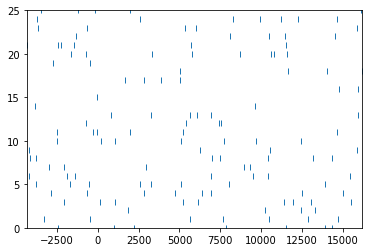

In [214]:
def spk_raster(syl_df, i_clu, spk_arr):
    spk_times = [spk_arr[i_clu, syl_idx].flatten() for syl_idx in syl_df.index]
    spk_trials = [np.ones_like(s)*i for i, s in enumerate(spk_times)]
    return spk_times, spk_trials

spikes, trials = spk_raster(voc_df[voc_df['fname']==all_epochs[2]], 175, spk_arr)

plt.plot(np.hstack(spikes), np.hstack(trials), '|')

Text(0.5, 1.0, 'epoch raw_dir_02_g0_t0.nidq.bin, clu 41')

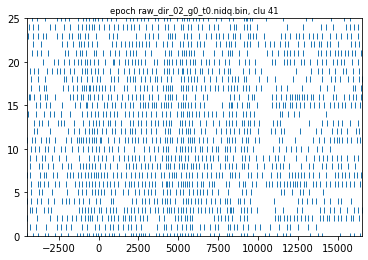

In [274]:
clu=41
epoch = all_epochs[2]
spikes, trials = spk_raster(voc_df[voc_df['fname']==epoch], clu, spk_arr)

plt.plot(np.hstack(spikes), np.hstack(trials), '|')
plt.title('epoch {}, clu {}'.format(epoch, clu))

<ipython-input-105-9f58ecefa1d0>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


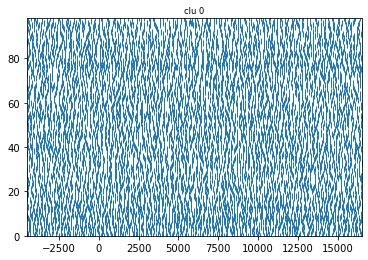

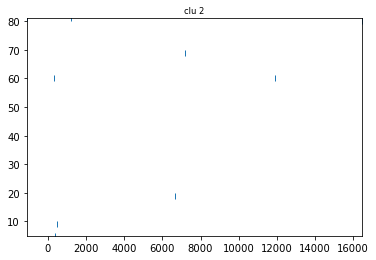

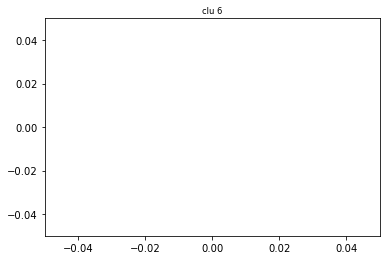

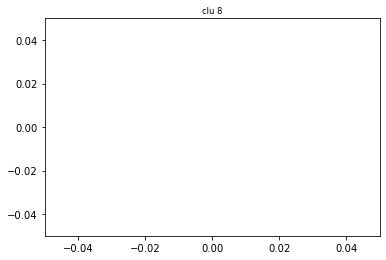

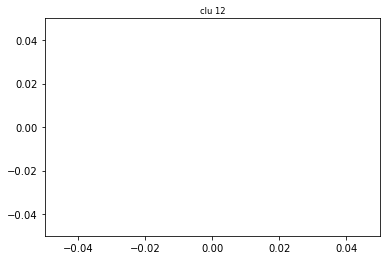

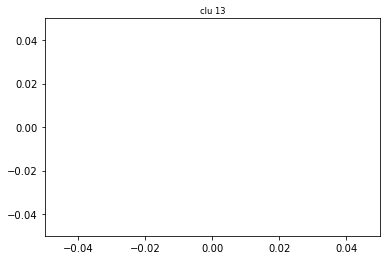

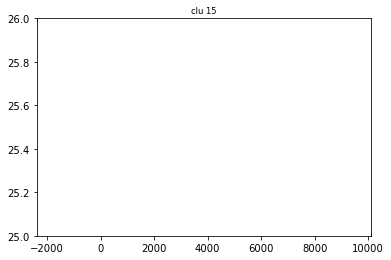

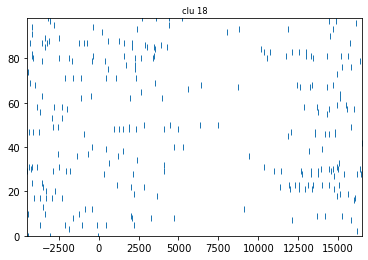

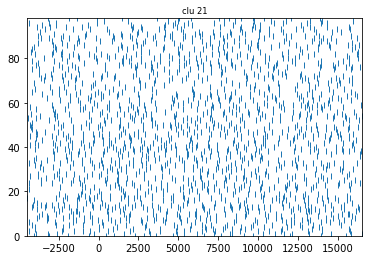

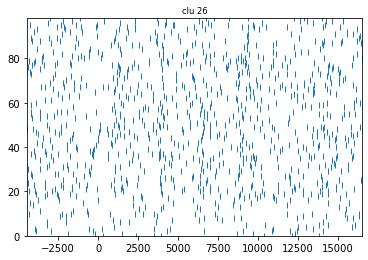

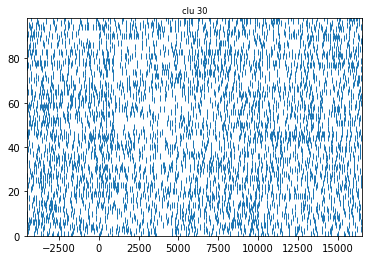

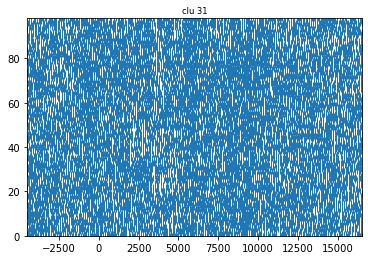

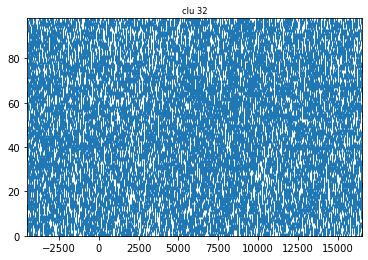

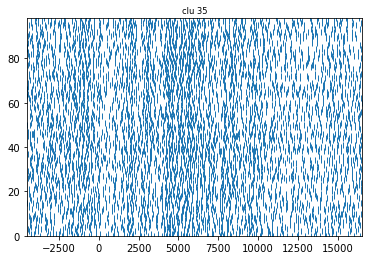

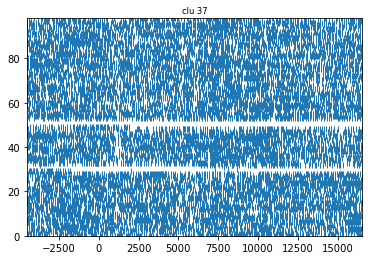

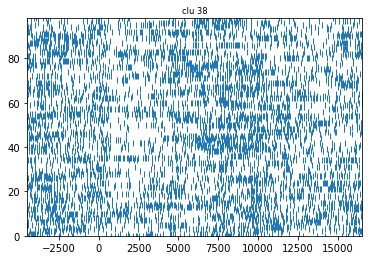

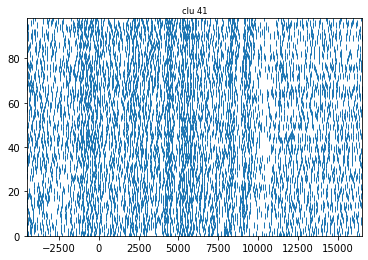

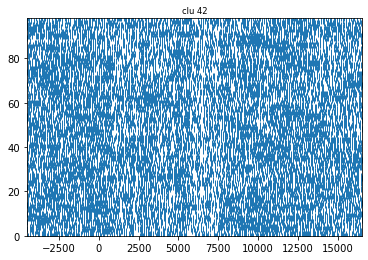

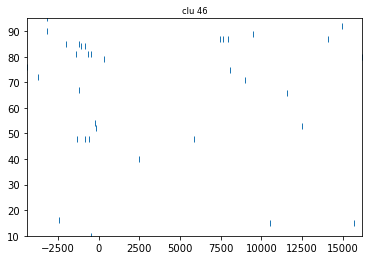

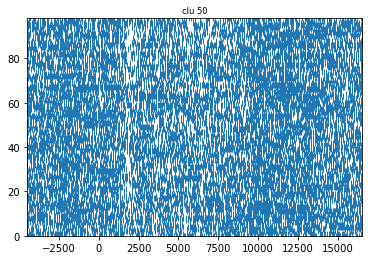

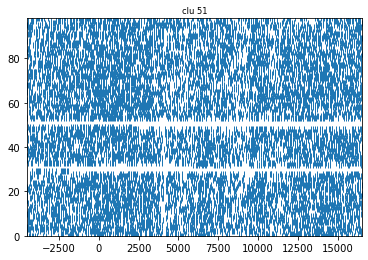

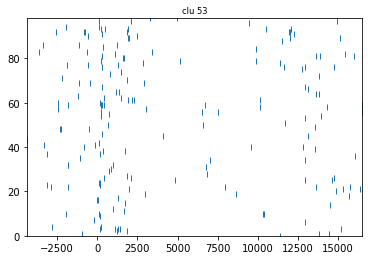

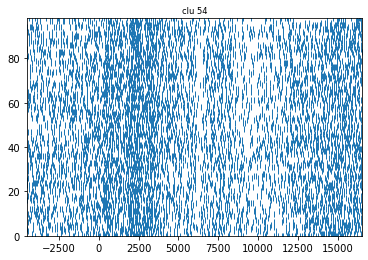

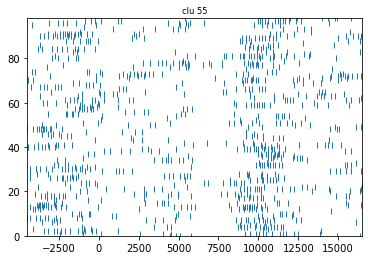

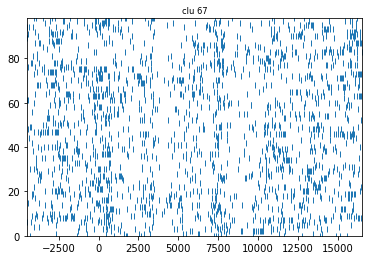

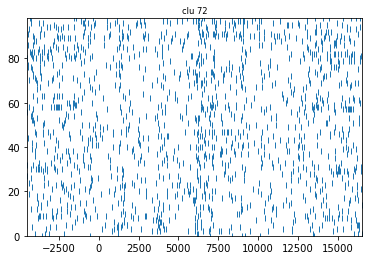

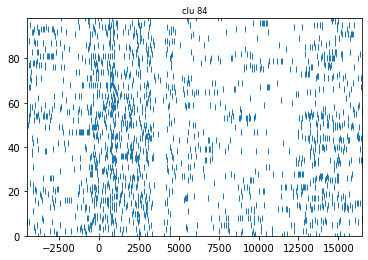

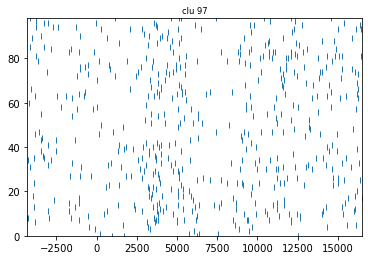

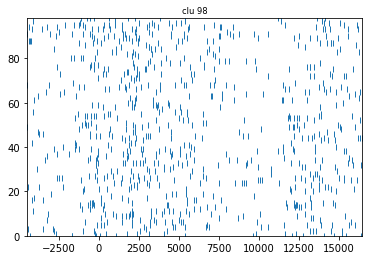

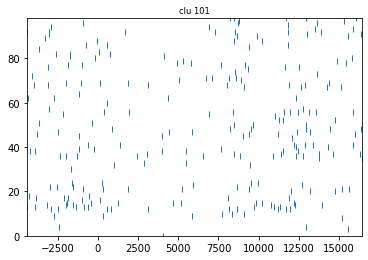

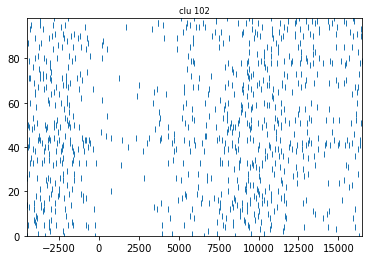

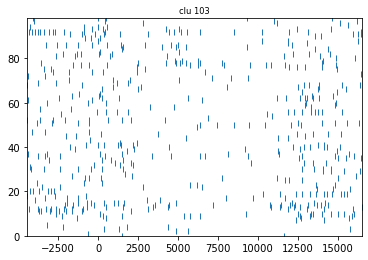

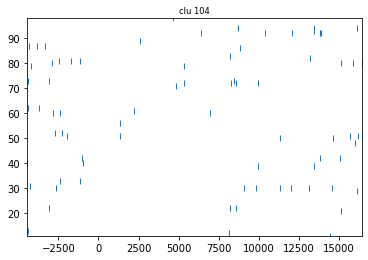

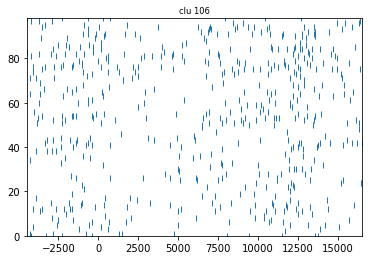

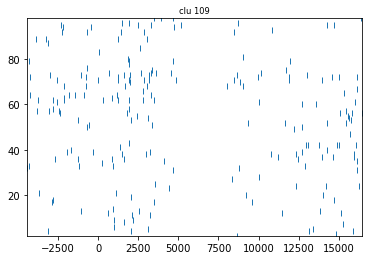

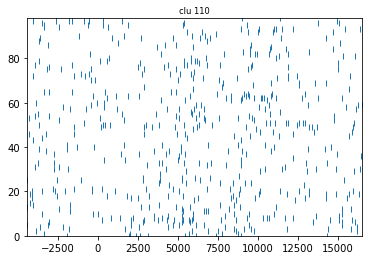

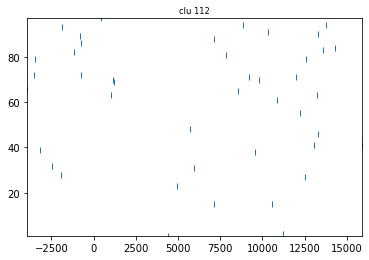

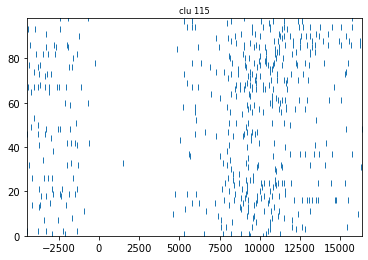

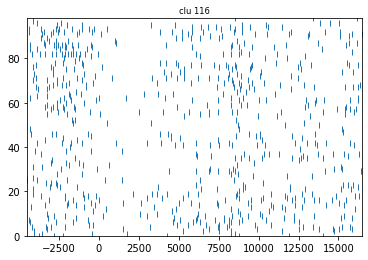

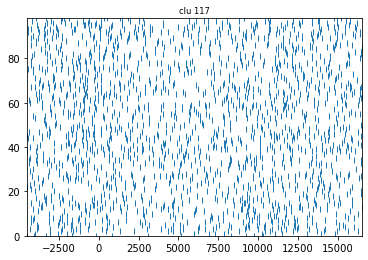

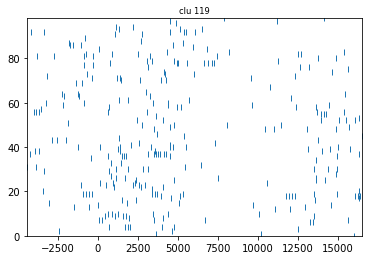

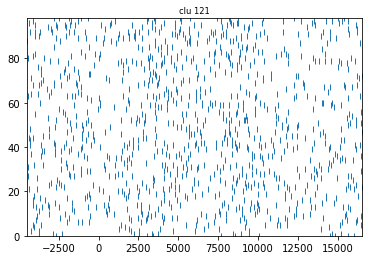

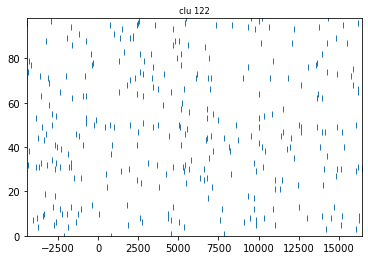

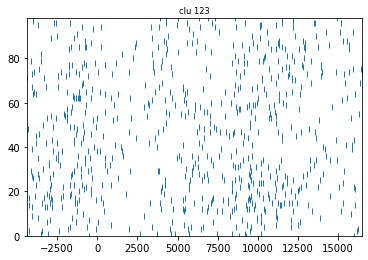

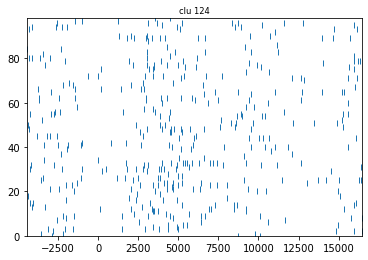

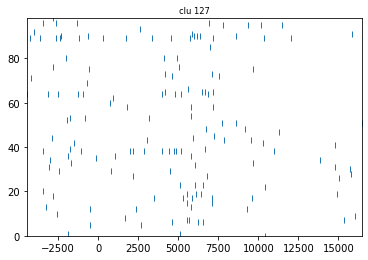

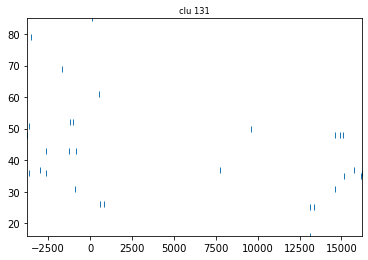

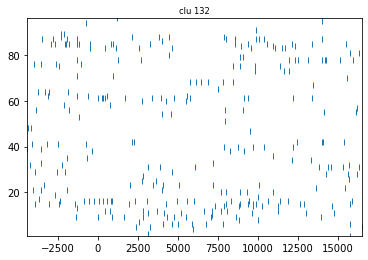

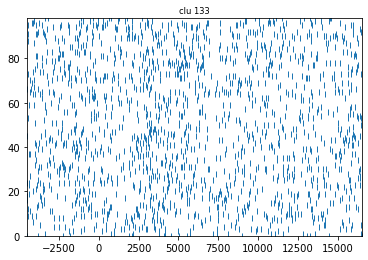

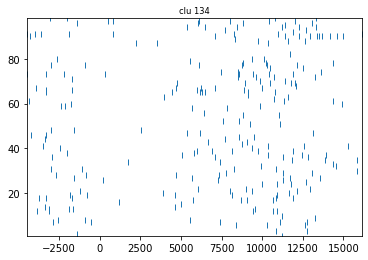

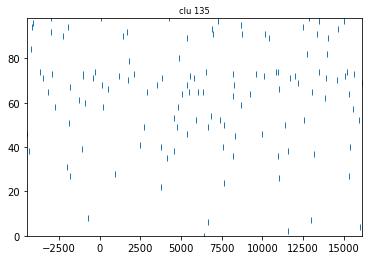

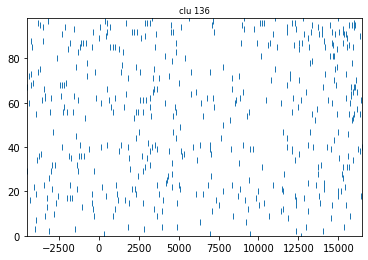

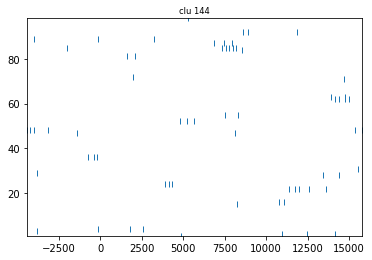

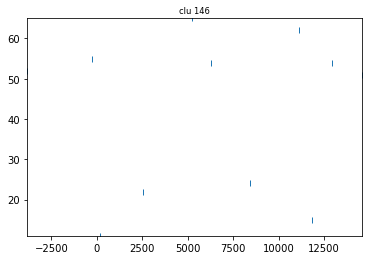

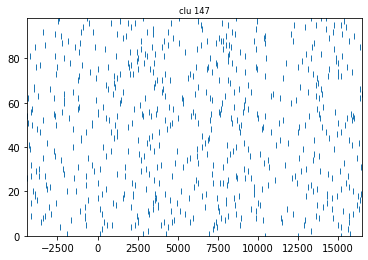

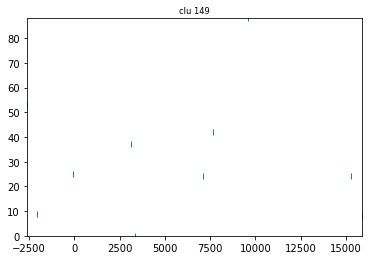

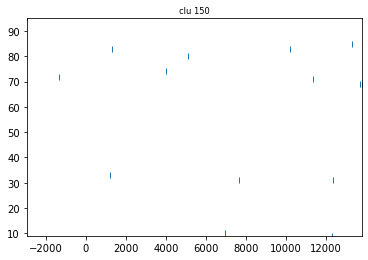

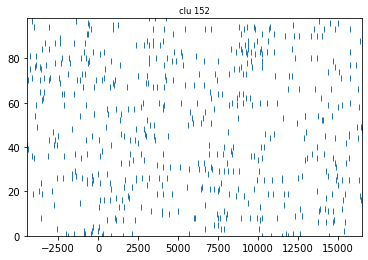

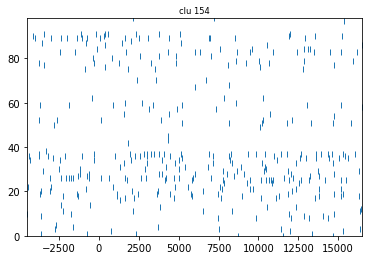

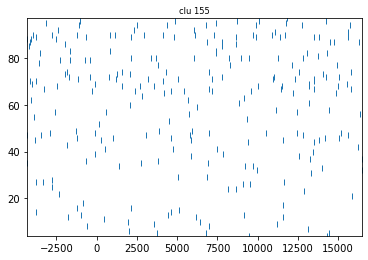

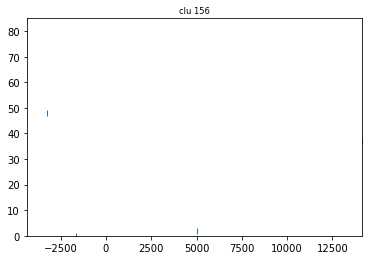

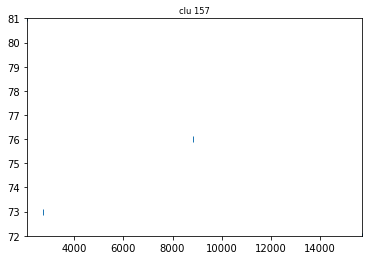

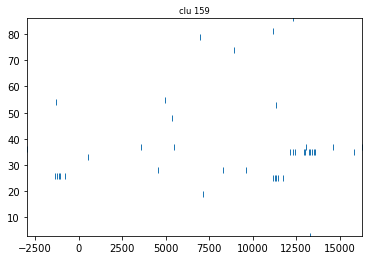

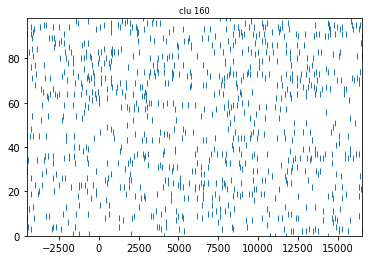

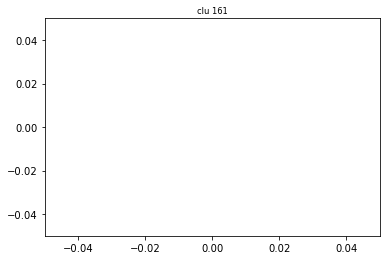

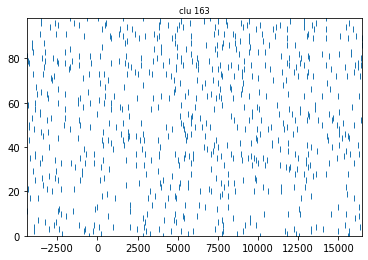

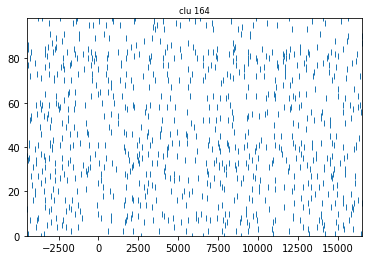

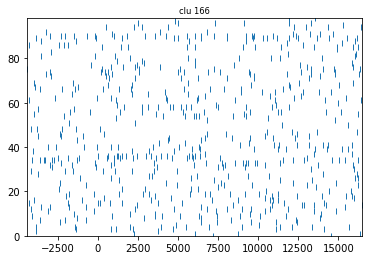

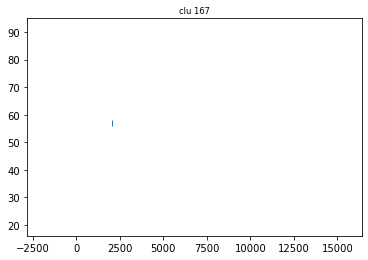

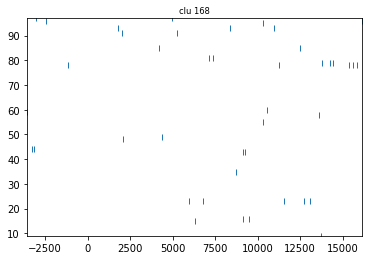

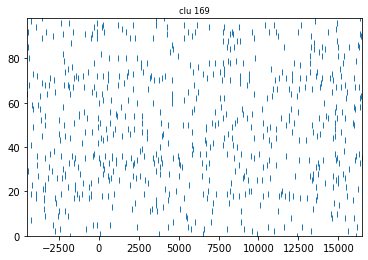

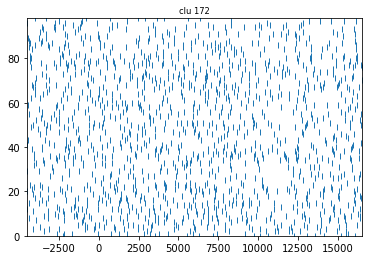

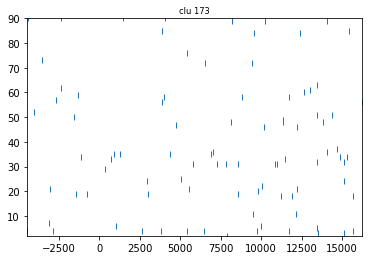

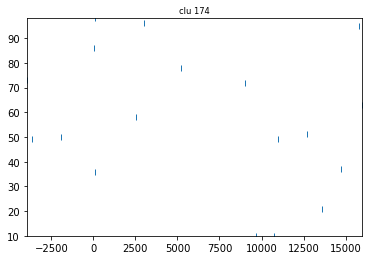

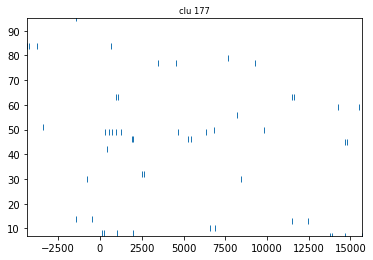

In [105]:
for clu in ap_df[ap_df['KSLabel']=='good'].index:
    spikes, trials = spk_raster(voc_df[voc_df['fname']==all_epochs[3]], clu, spk_arr)
    plt.figure()
    plt.plot(np.hstack(spikes), np.hstack(trials), '|')
    plt.title('clu {}'.format(clu)) 

<ipython-input-216-3aee83779ed9>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


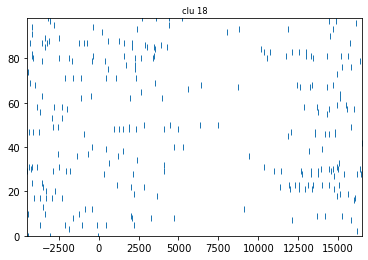

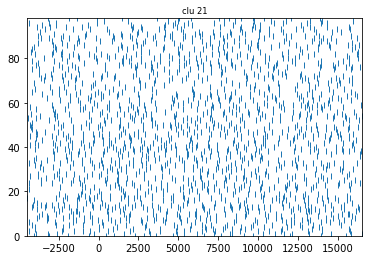

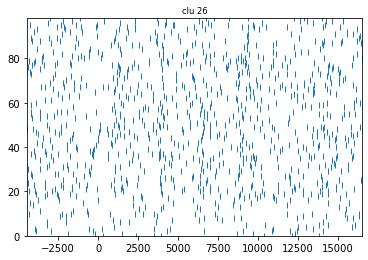

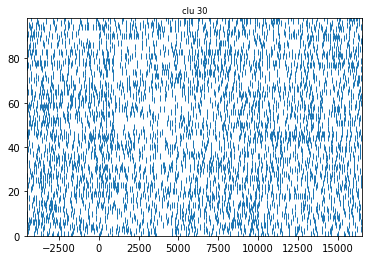

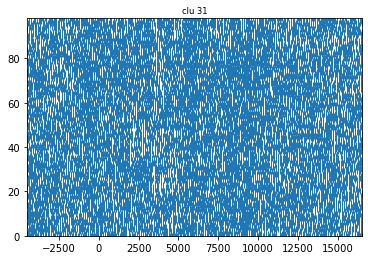

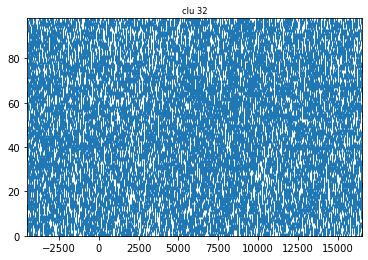

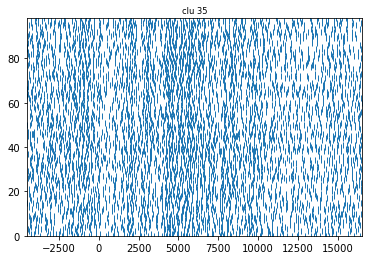

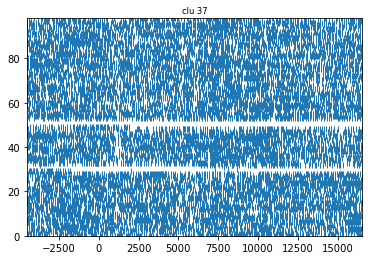

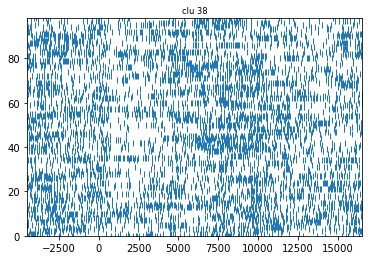

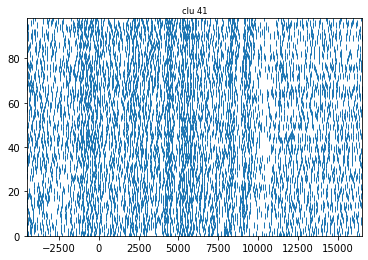

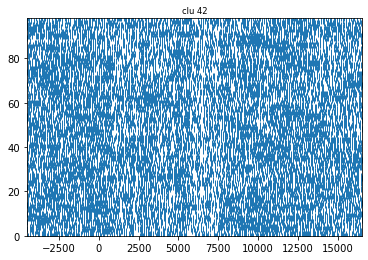

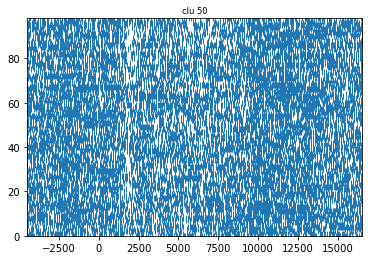

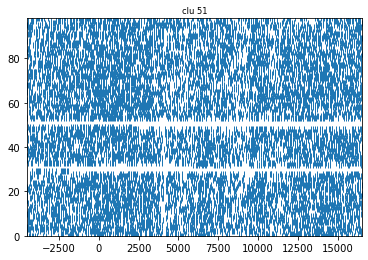

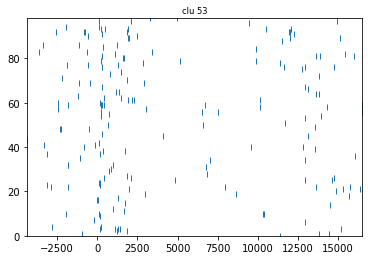

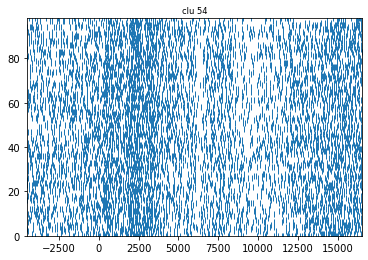

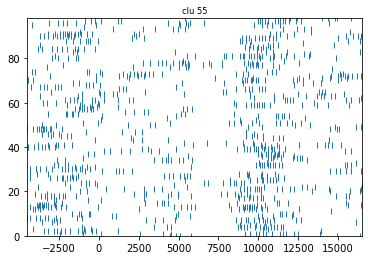

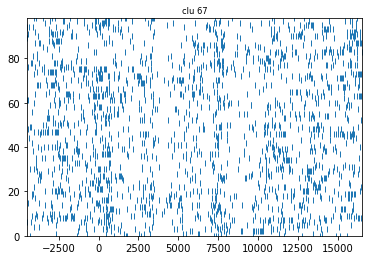

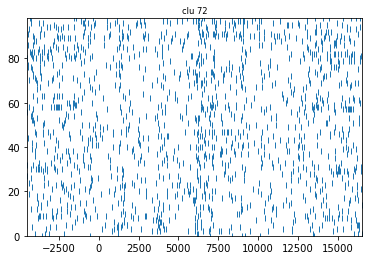

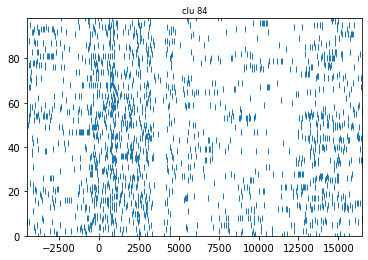

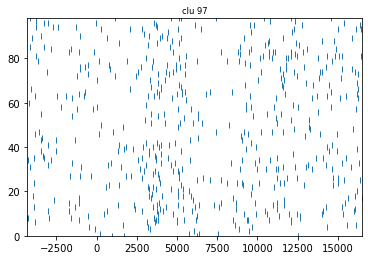

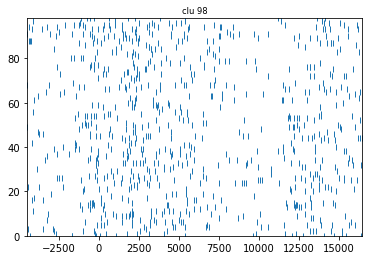

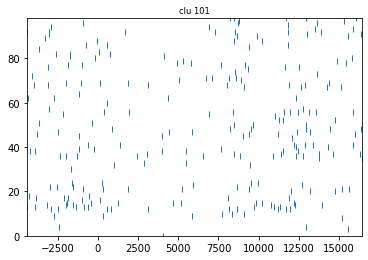

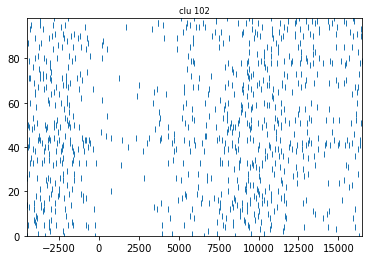

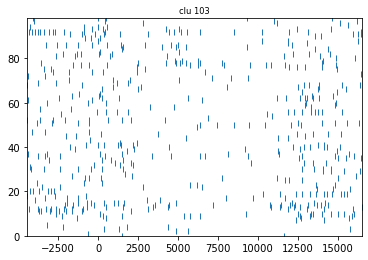

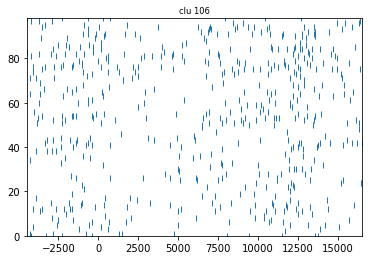

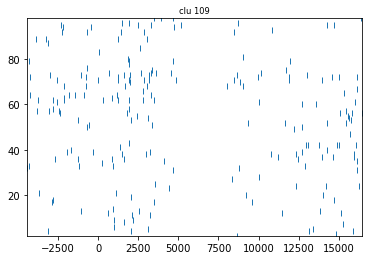

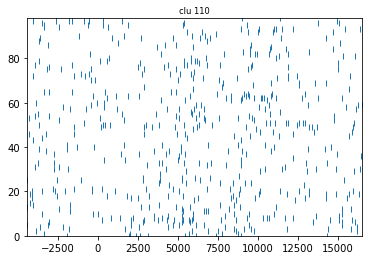

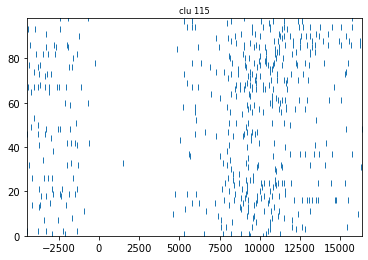

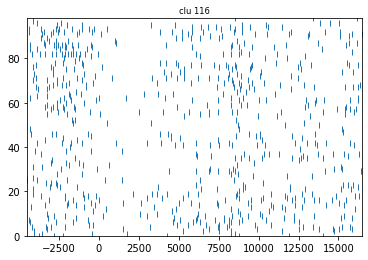

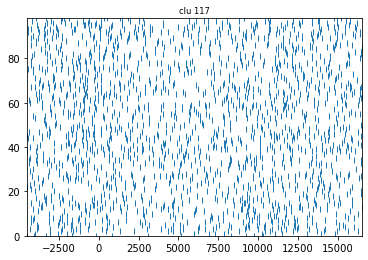

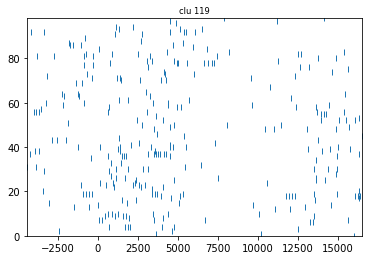

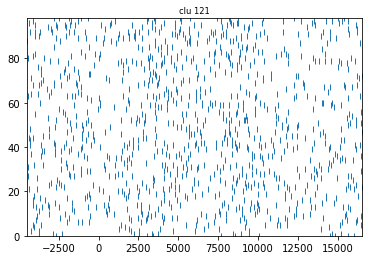

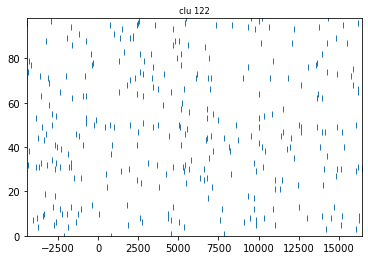

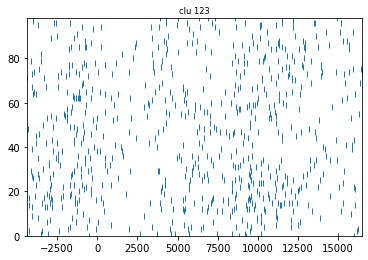

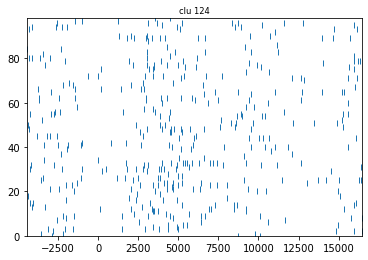

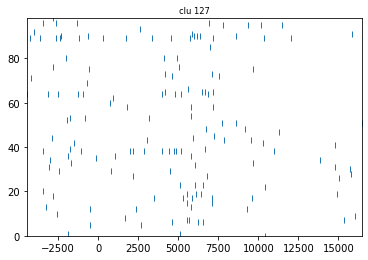

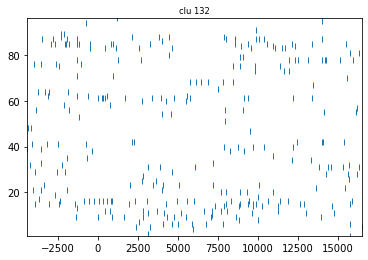

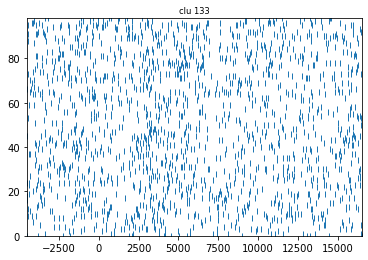

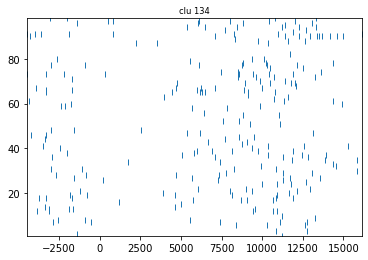

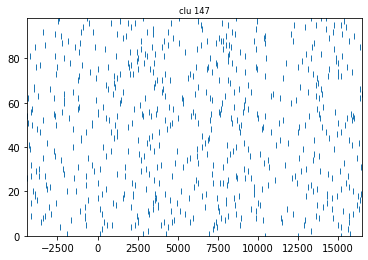

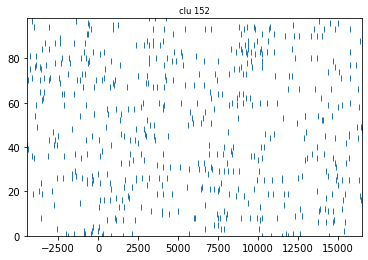

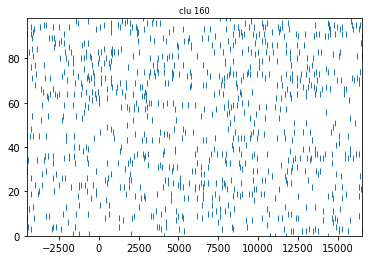

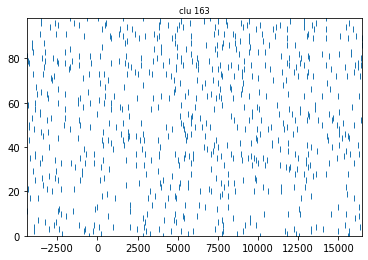

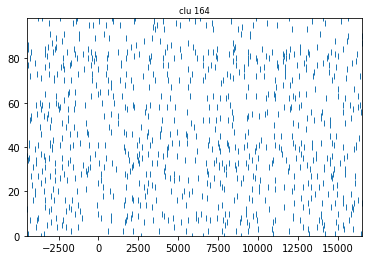

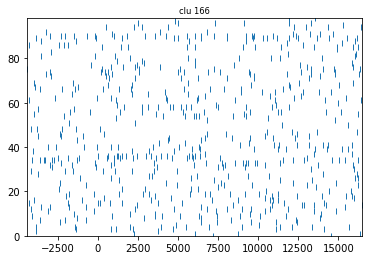

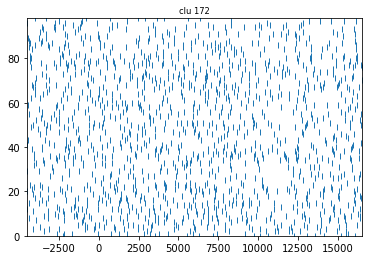

In [216]:
for clu in clu_list:
    spikes, trials = spk_raster(voc_df[voc_df['fname']==all_epochs[3]], clu, spk_arr)
    plt.figure()
    plt.plot(np.hstack(spikes), np.hstack(trials), '|')
    plt.title('clu {}'.format(clu)) 

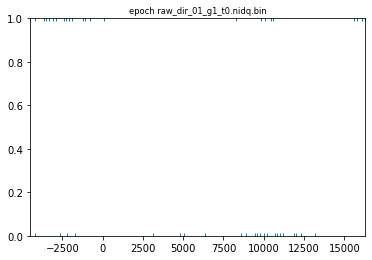

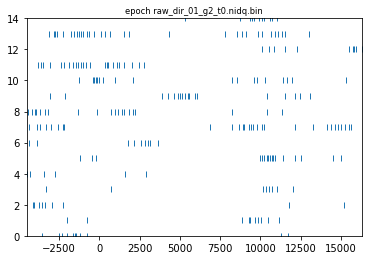

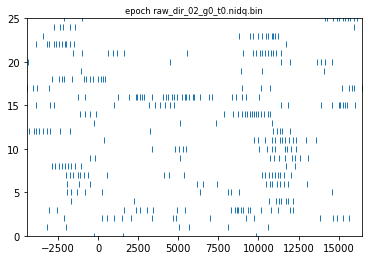

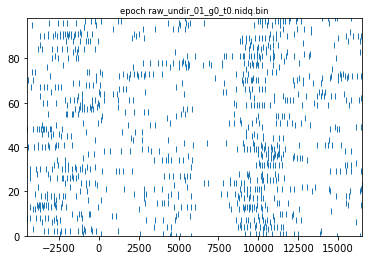

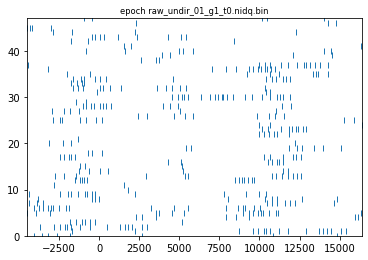

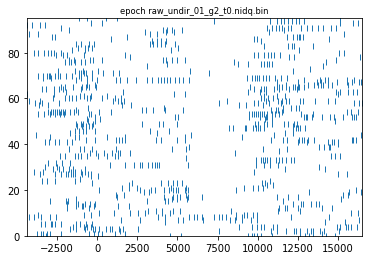

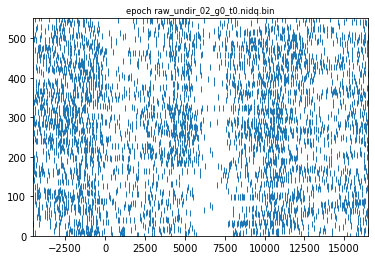

In [110]:
clu = 55 
for epoch in all_epochs:
    spikes, trials = spk_raster(voc_df[voc_df['fname']==epoch], clu, spk_arr)
    plt.figure()
    plt.plot(np.hstack(spikes), np.hstack(trials), '|')
    plt.title('epoch {}'.format(epoch)) 

In [ ]:
#### one syllable raster for all clusters

In [288]:
clu_list = [18, 21, 26, 30, 31, 32, 35, 37, 38, 41, 42, 50, 51, 53, 54, 55,
            67, 72, 84, 97, 98, 101, 102, 103, 106, 109, 110, 115, 116, 117, 119, 
            121, 122, 123, 124, 127, 132, 133, 134, 147, 152, 160, 163, 164, 166, 172]

ap_df.iloc[clu_list]['depth']

18      540
21      720
26      860
30      960
31     1040
32     1060
35     1280
37     1380
38     1400
41     1500
42     1520
50     1780
51     1960
53     2080
54     2120
55     2160
67     2480
72     2540
84     2600
97     2740
98     2740
101    2780
102    2780
103    2780
106    2800
109    2820
110    2820
115    2880
116    2880
117    2880
119    2900
121    2940
122    2960
123    2960
124    2960
127    2980
132    3100
133    3120
134    3140
147    3340
152    3560
160    3620
163    3640
164    3700
166    3700
172    3740
Name: depth, dtype: int64

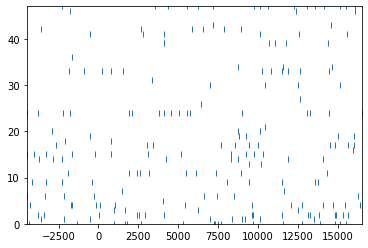

In [290]:
# clu_list = [18, 21, 26, 30, 31, 32, 35, 37, 38, 41, 42, 50, 51, 53, 54, 55,
#             67, 72, 84, 97, 98, 101, 102, 103, 106, 109, 110, 115, 116, 117, 119, 
#             121, 122, 123, 124, 127, 132, 133, 134, 147, 152, 160, 163, 164, 166, 172]

clu_list = ap_df[(ap_df['depth'].between(3000, 3800)) & (ap_df['KSLabel'].isin(['good']))].index

clu_list = ap_df[(ap_df['depth'].between(2200, 3800)) & (ap_df['KSLabel'].isin(['good', 'mua']))].index

#clu_list = [35, 41, 42, 50, 51, 54, 115, 117, 123, 133]

def syl_raster(syl_idx, clu_list, spk_arr):
    spk_times = [spk_arr[i_clu, syl_idx].flatten() for i_clu in clu_list]
    spk_trials = [np.ones_like(s)*i for i, s in enumerate(spk_times)]
    return spk_times, spk_trials

spikes, trials = syl_raster(0, clu_list, spk_arr)

plt.plot(np.hstack(spikes), np.hstack(trials), '|')

In [213]:
voc_df['clu_list'] = [clu_list for idx in voc_df.index]
voc_df['spk_list'] = [syl_raster(idx, clu_list, spk_arr) for idx in voc_df.index]

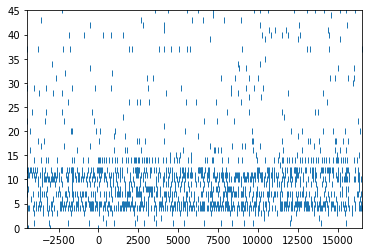

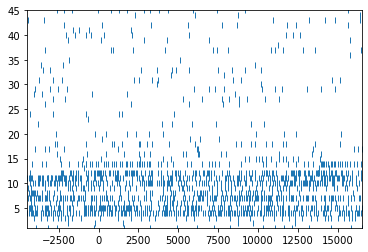

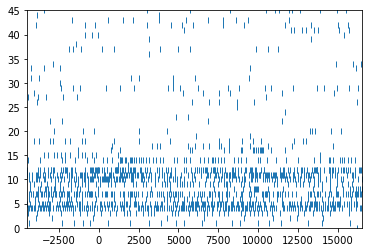

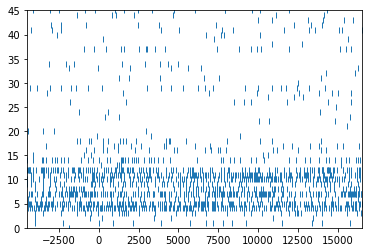

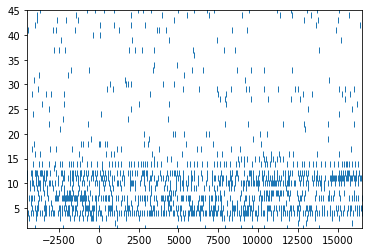

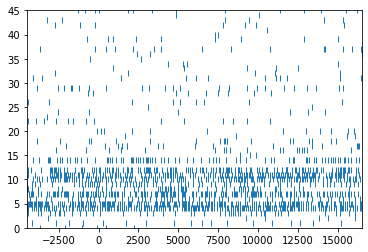

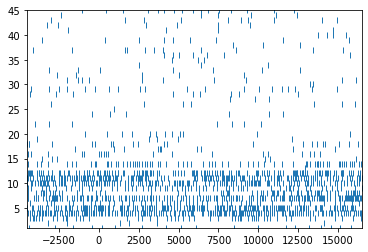

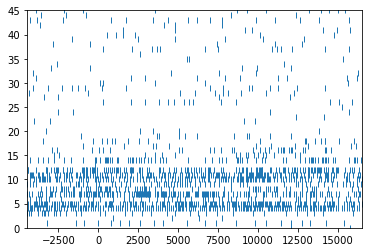

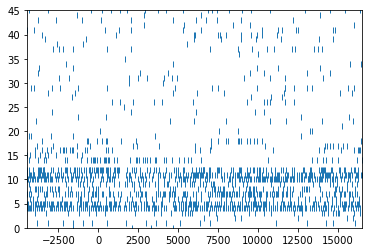

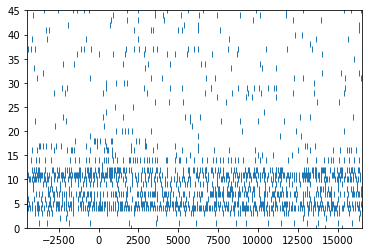

In [118]:
for syl_idx in range(10):
    spikes, trials = syl_raster(syl_idx, clu_list, spk_arr)
    plt.figure()
    plt.plot(np.hstack(spikes), np.hstack(trials), '|')
    

### get all the gpfa

In [119]:
import neo
import quantities as pq
from elephant.gpfa import GPFA
import viziphant as vp

Elephant wants nested lists of SpikeTrain objects.
[n_trials, n_spiketrains, n_spikes] (each spike is a time where a spike occurred)

The strategy is to do all the spiketrains, do the fit, then project each array and store that in the pandas dataframe bout_df

In [126]:
spikes[3]/30000

array([-0.13226667, -0.12713333, -0.11893333, -0.1083    , -0.10343333,
       -0.09786667, -0.0968    , -0.06613333, -0.0535    , -0.0216    ,
        0.0172    ,  0.03846667,  0.07353333,  0.14093333,  0.16126667,
        0.16916667,  0.18116667,  0.19326667,  0.19783333,  0.2198    ,
        0.2439    ,  0.26003333,  0.27336667,  0.28326667,  0.29046667,
        0.29586667,  0.30636667,  0.31756667,  0.32303333,  0.33      ,
        0.34506667,  0.3508    ,  0.3557    ,  0.3636    ,  0.3873    ,
        0.39133333,  0.39496667,  0.42816667,  0.43663333,  0.4475    ,
        0.4583    ,  0.4696    ,  0.48256667,  0.49116667,  0.49753333,
        0.5023    ,  0.52256667,  0.54606667])

In [291]:
def spike_trains_from_spk_arr(spk_arr_list, s_f=30000, t_start=-0.15, t_stop=0.55):
    spk_train_list = [neo.SpikeTrain(times = s/s_f - t_start, 
                      units='sec',
                      t_start=0,
                      t_stop=t_stop-t_start) for s in spk_arr_list]
    return spk_train_list


def all_syl_spk_trains(syl_df, clu_list, spk_arr):
    # for each syl, make the spk times list for the selected clusters
    spk_times_list = [syl_raster(syl_idx, clu_list, spk_arr)[0] for syl_idx in syl_df.index]
    # for each spk times list, make the neo spike trains
    spk_train_list = [spike_trains_from_spk_arr(s) for s in spk_times_list] 
    
    return spk_times_list, spk_train_list


#### Make two separate gpfa fits, one for the vocal part of the bout and one for the 'preparatory' part

In [292]:
# specify fitting parameters
gpfa_bin_ms = 15
bin_size = gpfa_bin_ms * pq.ms
latent_dimensionality = 8

dir_gpfa_8dim = GPFA(bin_size=bin_size, x_dim=latent_dimensionality)

spk_lst, trn_list = all_syl_spk_trains(voc_df, clu_list, spk_arr)

all_syl_fit_list = dir_gpfa_8dim.fit_transform(trn_list)
all_syl_fit_arr = np.stack(all_syl_fit_list, axis=0)
voc_df['gpfa'] = all_syl_fit_list

/mnt/cube/earneodo/envs/pakhi/ceciestunepipe/lib/python3.8/site-packages/elephant/conversion.py:1168: UserWarning: Binning discarded 3 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/mnt/cube/earneodo/envs/pakhi/ceciestunepipe/lib/python3.8/site-packages/elephant/utils.py:290: UserWarning: Correcting 1 rounding errors by shifting the affected spikes into the following bin. You can set tolerance=None to disable this behaviour.
  warnings.warn(f'Correcting {num_corrections} rounding errors by '
/mnt/cube/earneodo/envs/pakhi/ceciestunepipe/lib/python3.8/site-packages/elephant/conversion.py:1168: UserWarning: Binning discarded 5 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/mnt/cube/earneodo/envs/pakhi/ceciestunepipe/lib/python3.8/site-packages/elephant/conversion.py:1168: UserWarning: Binning discarded 4 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last 

Initializing parameters using factor analysis...

Fitting GPFA model...


/mnt/cube/earneodo/envs/pakhi/ceciestunepipe/lib/python3.8/site-packages/elephant/conversion.py:1168: UserWarning: Binning discarded 3 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/mnt/cube/earneodo/envs/pakhi/ceciestunepipe/lib/python3.8/site-packages/elephant/utils.py:290: UserWarning: Correcting 1 rounding errors by shifting the affected spikes into the following bin. You can set tolerance=None to disable this behaviour.
  warnings.warn(f'Correcting {num_corrections} rounding errors by '
/mnt/cube/earneodo/envs/pakhi/ceciestunepipe/lib/python3.8/site-packages/elephant/conversion.py:1168: UserWarning: Binning discarded 5 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/mnt/cube/earneodo/envs/pakhi/ceciestunepipe/lib/python3.8/site-packages/elephant/conversion.py:1168: UserWarning: Binning discarded 4 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last 

In [293]:
voc_df['gpfa'] = all_syl_fit_list

#### fit the vocal part, project all to this fit

In [294]:
dir_gpfa = np.stack(voc_df[voc_df['undir']==False]['gpfa'], axis=0)
undir_gpfa = np.stack(voc_df[voc_df['undir']==True]['gpfa'], axis=0)

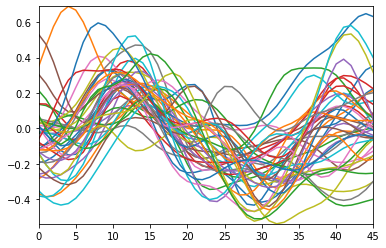

In [295]:
plt.plot(dir_gpfa[:,0].T);

In [296]:
# to balance it
n_dir = dir_gpfa.shape[0]
n_undir = undir_gpfa.shape[0]
random_undir = np.random.randint(0, n_undir, n_dir)

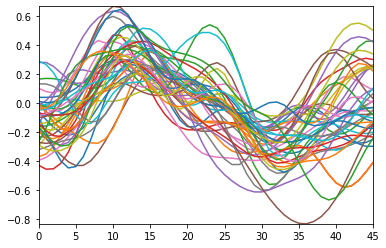

In [297]:
plt.plot(undir_gpfa[random_undir,0].T);

In [298]:
def plot_mean(x, ax=None, err=None, **kwargs):
    if ax is None:
        fig, ax = plt.subplots()
    if err is None:
        x_ = np.mean(x, axis=-1)
        err = np.std(x, axis=-1)
    else:
        x_ = x
    
    ax.plot(x_, **kwargs)
    #ax.plot(x_+err, **kwargs)
    ax.fill_between(np.arange(x_.size), x_-err, x_+err, alpha=0.2, **kwargs)
    return ax

<AxesSubplot:>

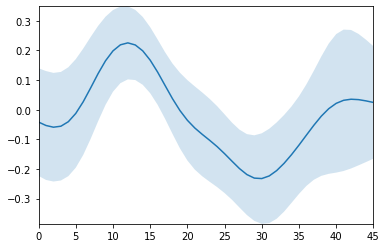

In [299]:
plot_mean(dir_gpfa[:,0,:].T)

<AxesSubplot:>

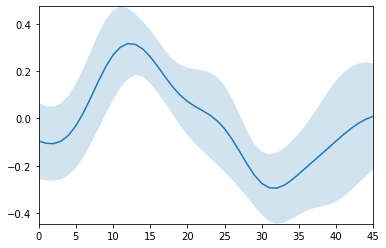

In [300]:
plot_mean(undir_gpfa[random_undir,0,:].T)